In [1]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['PYTHONHASHSEED'] = str(50)

from collections import defaultdict
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential


In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Separate data and labels
drop_labels = ['GroundTruthRange[m]']
X = data.drop(columns = drop_labels)
y = data['GroundTruthRange[m]']

# Quick Data Stats
print(f'Number of samples: {data.shape[0]}')
features = data.shape[1] - len(drop_labels)
print(f'Features per sample: {features}\n')

print(f'Columns:')
for i in data.columns[:-1]:
    if i in drop_labels:
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '\n\n')


Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]



In [3]:
seed = 11
clients = {'Client Data': [], 'Client Labels': [], 'Client Distances': []}
X_val = []
Y_val = []
X_test = []
Y_test = []
total = 0
for i in range(1, 13):
    condition = (X['AP_index'] == i)
    curr_data = X[condition].to_numpy()
    curr_labs = y[condition].to_numpy()
    
    x_split, x_val, y_split, y_val = train_test_split(curr_data, curr_labs, test_size = 0.2, random_state = seed)
    x_train, x_test, y_train, y_test = train_test_split(x_split, y_split, test_size = 0.25, random_state = seed)
    clients['Client Data'].append(x_train)
    clients['Client Labels'].append(y_train)
    X_val.append(x_val)
    Y_val.append(y_val)
    X_test.append(x_test)
    Y_test.append(y_test)


In [4]:
xval_tot = 0
xtest_tot = 0
for i in range(12):
    xval_tot += len(X_val[i])
    xtest_tot += len(X_test[i])

# before, 2nd arg was features instead of 5
X_val_data = np.zeros((xval_tot, features))
y_val_labels = np.zeros(xval_tot)
X_test_data = np.zeros((xtest_tot, features))
y_test_labels = np.zeros(xtest_tot)
idx_val = 0
idx_test = 0
for client_val, client_test in zip(zip(X_val, Y_val), zip(X_test, Y_test)):
    for i, j in zip(client_val[0], client_val[1]):
        X_val_data[idx_val] = i
        y_val_labels[idx_val] = j
        idx_val += 1
    for i, j in zip(client_test[0], client_test[1]):
        X_test_data[idx_test] = i
        y_test_labels[idx_test] = j
        idx_test += 1

scaler = StandardScaler()


np.random.seed(seed)
clients['Client Distances'] = np.random.rand(len(clients['Client Data'])) / 2

fed = FederatedSystem(clients['Client Data'], clients['Client Labels'], clients['Client Distances'])
fed.SetValData({'Val Data': X_val_data, 'Val Labels': y_val_labels})
fed.SetTestData({'Data': X_test_data, 'Labels': y_test_labels})


In [15]:
tf.keras.utils.set_random_seed(50)
tf.config.experimental.enable_op_determinism()
model = Sequential([
    #16
    layers.Dense(16, activation = 'relu', input_shape = (10,)),
    #layers.BatchNormalization(),
    #8
    layers.Dense(8, activation = 'relu'),
    layers.LayerNormalization(),
    #layers.BatchNormalization(),
    #4, usually have this last layer
    #layers.Dense(8, activation = 'relu'),
    layers.Dense(1)
])
#16 8 8 1

fed.SetModel(model)
fed.clear_history()

In [16]:
context = [0, 4]
Mt = (np.ones(50) * 5).astype('int32')
#fed.SetContextElements(context)
#0.01, 0.01, lr 0.005, epoch = 20
w, b = fed.ConFeddi(1000, 10, lr = 0.005, rounds = 20, Mt = Mt)
mse = fed.test_loss()
log = fed.GetLog()
fed.clear_history()

Round 5
Round 10
Round 15
Round 20


In [17]:
w, b = fed.FedAvg(rounds = 20, lr = 0.005, frac_clients = (5/12))
fedavg_mse = fed.test_loss()
fedavg_log = fed.GetLog()
fed.clear_history()

Round 5
Round 10
Round 15
Round 20


In [18]:
#np.save('history/important baselines/fedavg_test_mse_newmodel.npy', fedavg_mse)
#np.save('history/important baselines/fedavg_log_newmodel.npy', fedavg_log)

29.533042907714844


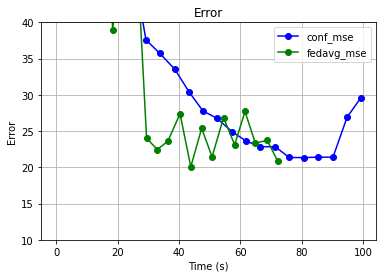

In [19]:
plt.plot(log, mse, color = 'blue', label = 'conf_mse', marker = 'o')
plt.plot(fedavg_log, fedavg_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
plt.title('Error')
plt.ylim(10, 40)
plt.ylabel('Error')
plt.xlabel('Time (s)')
plt.grid()
plt.legend()

print(mse[-1])
fed.clear_history()

# Grid Analysis

In [22]:
rounds = 20
a_search = np.logspace(-2, 3, 6)
l_search = np.logspace(-3, 1, 5)
history = dict()
Mt = (np.ones(rounds) * 5).astype('int32')
count = 1
for i, a in enumerate(a_search):
    for j, l in enumerate(l_search):
        print(f'Training Model {count}')
        w, b = fed.ConFeddi(a, l, lr = 0.005, rounds = rounds, Mt = Mt)
        history[(a, l)] = (fed.test_loss(), fed.GetLog())
        count += 1
        fed.clear_history()
        print()

Training Model 1
Round 5
Round 10
Round 15
Round 20

Training Model 2
Round 5
Round 10
Round 15
Round 20

Training Model 3
Round 5
Round 10
Round 15
Round 20

Training Model 4
Round 5
Round 10
Round 15
Round 20

Training Model 5
Round 5
Round 10
Round 15
Round 20

Training Model 6
Round 5
Round 10
Round 15
Round 20

Training Model 7
Round 5
Round 10
Round 15
Round 20

Training Model 8
Round 5
Round 10
Round 15
Round 20

Training Model 9
Round 5
Round 10
Round 15
Round 20

Training Model 10
Round 5
Round 10
Round 15
Round 20

Training Model 11
Round 5
Round 10
Round 15
Round 20

Training Model 12
Round 5
Round 10
Round 15
Round 20

Training Model 13
Round 5
Round 10
Round 15
Round 20

Training Model 14
Round 5
Round 10
Round 15
Round 20

Training Model 15
Round 5
Round 10
Round 15
Round 20

Training Model 16
Round 5
Round 10
Round 15
Round 20

Training Model 17
Round 5
Round 10
Round 15
Round 20

Training Model 18
Round 5
Round 10
Round 15
Round 20

Training Model 19
Round 5
Round 10
Ro

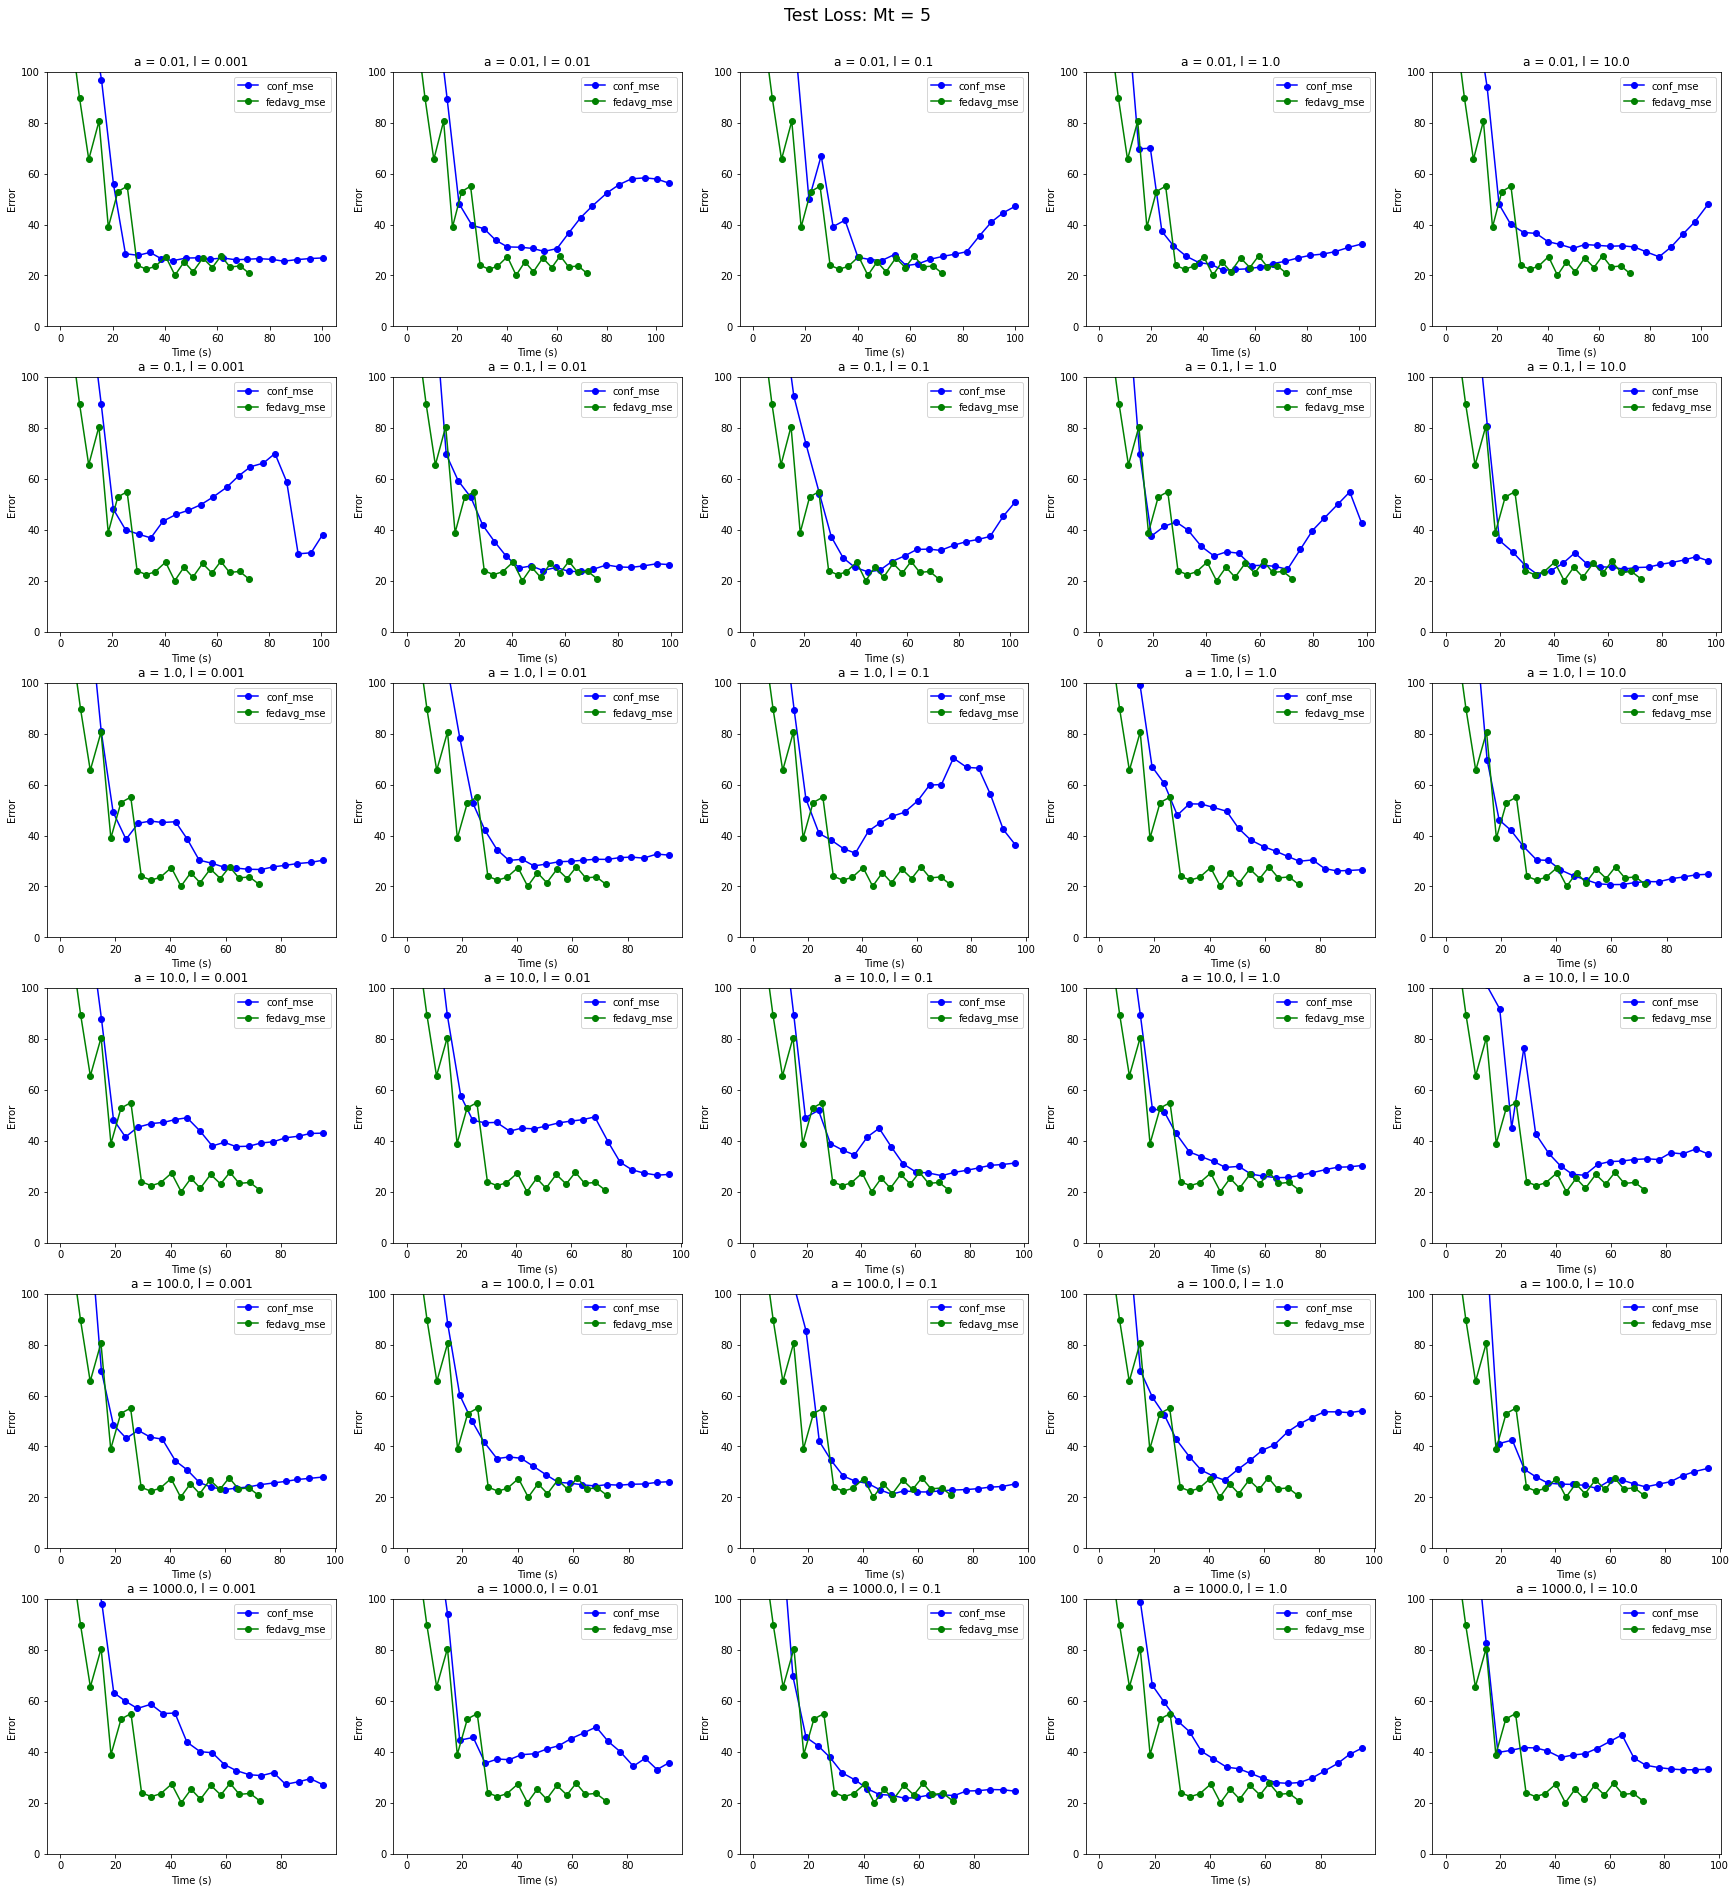

In [25]:
r, c, = 6, 5
fig = plt.figure(figsize = (30, 30))
plt.suptitle('Test Loss: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)

plot = 1
for run in history.items():
    a, l = run[0]
    err,  time=  run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
    plt.title(f'a = {a}, l = {l}')
    plt.ylim(0, 100)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.legend()

    #print(f'a = {a}, l = {l}, Final mse: {err[-1]}')

    plot += 1

# Ablation

In [28]:
history = dict()
base_mse = dict()
base_log = dict()
Mt = (np.ones(50) * 5).astype('int32')

context_elements = [
    [0, 1, 2, 3, 4],
    [0],
    [1],
    [2],
    [3],
    [4],
    [1, 2, 3, 4],
    [0, 2, 3, 4],
    [0, 1, 3, 4],
    [0, 1, 2, 4],
    [0, 1, 2, 3]
]

count = 1
for context in context_elements:
    print(f'Training Model {count}')
    fed.SetContextElements(context)
    w, b = fed.ConFeddi(1000, 0.1, rounds = 20, Mt = Mt)
    mse = fed.test_loss()
    log = fed.GetLog()
    history[tuple(context)] = (mse, log)
    count += 1

    if context == [0, 1, 2, 3, 4]:
        base_mse[tuple(context)] = mse
        base_log[tuple(context)] = log
    fed.clear_history()
    print()

Training Model 1
Round 5
Round 10
Round 15
Round 20

Training Model 2
Round 5
Round 10
Round 15
Round 20

Training Model 3
Round 5
Round 10
Round 15
Round 20

Training Model 4
Round 5
Round 10
Round 15
Round 20

Training Model 5
Round 5
Round 10
Round 15
Round 20

Training Model 6
Round 5
Round 10
Round 15
Round 20

Training Model 7
Round 5
Round 10
Round 15
Round 20

Training Model 8
Round 5
Round 10
Round 15
Round 20

Training Model 9
Round 5
Round 10
Round 15
Round 20

Training Model 10
Round 5
Round 10
Round 15
Round 20

Training Model 11
Round 5
Round 10
Round 15
Round 20



Final FedAvg: 20.84800148010254
context = (0,), True, Final Test Error: 20.842918395996094
context = (1,), False, Final Test Error: 37.61098098754883
context = (2,), False, Final Test Error: 31.33140754699707
context = (3,), False, Final Test Error: 27.913053512573242
context = (4,), True, Final Test Error: 19.33925437927246
context = (1, 2, 3, 4), False, Final Test Error: 39.94093704223633
context = (0, 2, 3, 4), False, Final Test Error: 23.32131004333496
context = (0, 1, 3, 4), False, Final Test Error: 34.405311584472656
context = (0, 1, 2, 4), False, Final Test Error: 28.641639709472656
context = (0, 1, 2, 3), False, Final Test Error: 27.430517196655273


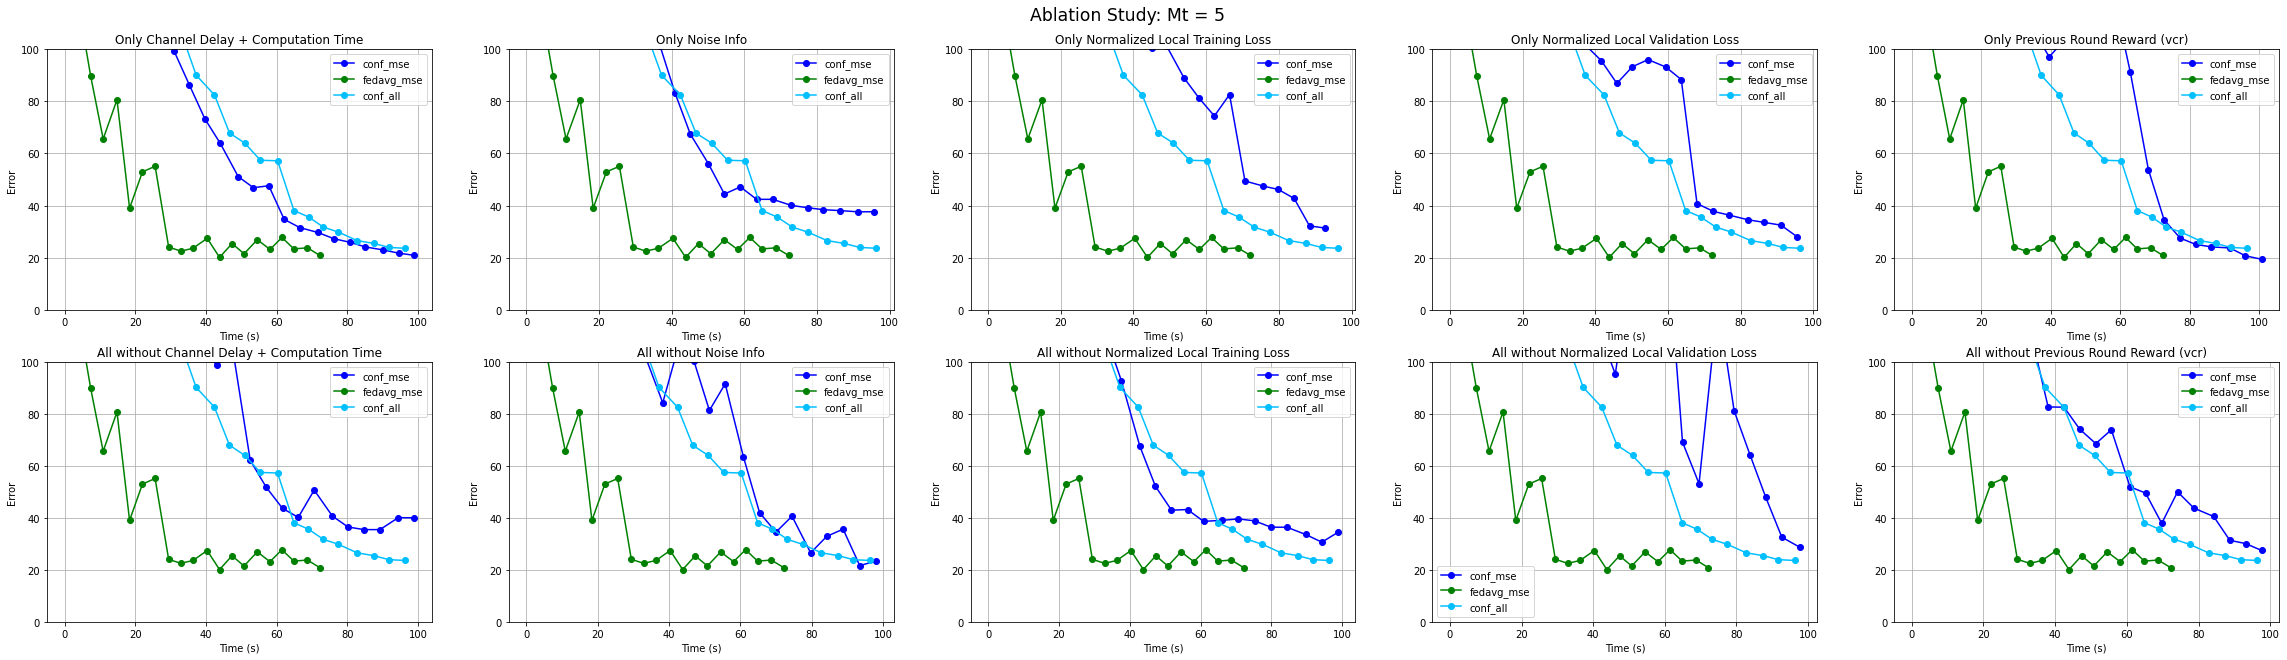

In [33]:
r, c, = 2, 5
fig = plt.figure(figsize = (40, 10))
plt.suptitle('Ablation Study: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)
print(f'Final FedAvg: {fedavg_mse[-1]}')

titles = {
    (0,): 'Only Channel Delay + Computation Time',
    (1,): 'Only Noise Info',
    (2,): 'Only Normalized Local Training Loss',
    (3,): 'Only Normalized Local Validation Loss',
    (4,): 'Only Previous Round Reward (vcr)',
    (1, 2, 3, 4): 'All without Channel Delay + Computation Time',
    (0, 2, 3, 4): 'All without Noise Info',
    (0, 1, 3, 4): 'All without Normalized Local Training Loss',
    (0, 1, 2, 4): 'All without Normalized Local Validation Loss',
    (0, 1, 2, 3): 'All without Previous Round Reward (vcr)'
}

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
    

    plt.plot(base_log[tuple([0, 1, 2, 3, 4])], base_mse[tuple([0, 1, 2, 3, 4])], color = 'deepskyblue', label = 'conf_all', marker = 'o')

    # When using final a and l, change title to Remove <specific context>
    plt.title(titles[context])
    plt.ylim(0, 100)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.grid()
    plt.legend()

    print(f'context = {context}, {fedavg_mse[-1] > err[-1]}, Final Test Error: {err[-1]}')

    plot += 1

In [32]:
for x in clients['Client Data']:
    print(len(x) / 29581)

0.06216828369561543
0.06115411919813394
0.04756431493188195
0.04898414522835604
0.0420878266454819
0.04499509820492884
0.06365572495858829
0.05912579020317096
0.05976809438490923
0.053852134816267196
0.026909164666508906
0.029512186876711404
